* Only showing the result of Visium OCT 
* Since the thickness of Visium OCT (5um) and FFPE (10um) are different

# Import modules

In [55]:
import os
import numpy as np
import scanpy as sc
import anndata
import pandas as pd
import matplotlib as mpl
# enables correct plotting of text
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 
import matplotlib.pyplot as plt
import seaborn as sns

import squidpy as sq

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [2]:
import session_info
session_info.show()

In [51]:
sc.settings.set_figure_params(dpi=80,dpi_save=300)

In [52]:
import importlib.util
import sys

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = utils
spec.loader.exec_module(utils)

spec = importlib.util.spec_from_file_location("module.name", "/nfs/team205/kk18/function/python/tissueaxis.py")
tissueaxis = importlib.util.module_from_spec(spec)
sys.modules["module.name"] = tissueaxis
spec.loader.exec_module(tissueaxis)

In [53]:
figdir = '/nfs/team205/heart/fetal_ms_figures/raw_plots_kk'

# Functions

In [5]:
# This function selects the data for multiple slides from the spatial anndata object.
# Modified `select_slide` in cell2loc for multiple slides

# @param adata: anndata object with multiple spatial experiments
# @param s: list of selected slides
# @param s_col: column in adata.obs listing experiment name for each location

def select_multislide(adata, s, s_col='sample'):

    slides = adata[adata.obs[s_col].isin(s), :]
    s_keys = list(slides.uns['spatial'].keys())
    
    uns_dict = {}
    for ss in s:
        s_spatial=np.array(s_keys)[[ss in k for k in s_keys]][0]
        uns_dict[s_spatial]=slides.uns['spatial'][s_spatial]
    
    slides.uns['spatial'] = uns_dict

    return slides

# Read in adata

In [19]:
adata_oct_healthy = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT_foetal_raw.h5ad')
print(adata_oct_healthy.shape)
adata_oct_healthy_LV = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-LV_foetal_raw.h5ad')
print(adata_oct_healthy_LV.shape)
adata_oct_t21 = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/visium-OCT-T21_foetal_raw.h5ad')
print(adata_oct_t21.shape)

(14261, 33538)
(6767, 33538)
(11238, 33538)


In [24]:
# concatenate oct adata
adata_oct_healthy_LV.obs['status'] = 'Healthy'
adata_oct_t21.obs['status'] = 'Trisomy21'

adata_oct = adata_oct_healthy.concatenate(
    [adata_oct_healthy_LV,adata_oct_t21],
    batch_key=None,
    index_unique=None,
    join="inner"
)

adata_oct.obs['status'].value_counts()

status
Healthy      21028
Trisomy21    11238
Name: count, dtype: int64

# Add axis

In [25]:
# add
oct_samples = list(set(adata_oct.obs['sample']))

adata_oct.obs['transmural_axis'] = np.nan

axis_files = os.listdir('/nfs/team205/heart/visium_axis/foetal/transmural_LV')
for file in axis_files:
    # read in
    axis = pd.read_csv(f'/nfs/team205/heart/visium_axis/foetal/transmural_LV/{file}',index_col=0)
    # add to anndata
    if file.split('.csv')[0] in oct_samples:
        adata_oct.obs.loc[axis.index,'transmural_axis'] = axis.copy()

# select spots with axis
adata_oct = adata_oct[adata_oct.obs['transmural_axis'].isna()==False]

In [26]:
# remove nuclei segmentation failed samples: 20PCW samples
adata_oct = adata_oct[adata_oct.obs['sample'].isin(['HCAHeartST13162330','HCAHeartST13162331'])==False]

# Load calculated image features and add to anndata

In [27]:
!ls /nfs/team205/heart/visium_axis/foetal/nuclei_segmentation/calculated_img_features

BHF_F_Hea13295830_img_features.csv   HCAHeartST11605167_img_features.csv
BHF_F_Hea13295831_img_features.csv   HCAHeartST11605168_img_features.csv
HCAHeartST10317184_img_features.csv  HCAHeartST13162330_img_features.csv
HCAHeartST10317185_img_features.csv  HCAHeartST13162331_img_features.csv
HCAHeartST10317186_img_features.csv  HCAHeartST13162336_img_features.csv
HCAHeartST11605165_img_features.csv


In [28]:
path_to_calculated_img_features = '/nfs/team205/heart/visium_axis/foetal/nuclei_segmentation/calculated_img_features'
img_feature_files = os.listdir(path_to_calculated_img_features)
len(img_feature_files)

11

In [29]:
for file in img_feature_files:
    # read in
    features = pd.read_csv(f'{path_to_calculated_img_features}/{file}',index_col=0)
    # add
    if file.split('_img')[0] in ['BHF_F_Hea13295830','BHF_F_Hea13295831']:
        continue
    else:
        cell_ids = list(set(features.index).intersection(adata_oct.obs_names))
        adata_oct.obs.loc[cell_ids,features.columns] = features

# checking whether all cells have feature
print(sum(adata_oct.obs['segmentation_label'].isna())==0)

True


In [30]:
features.head()

,segmentation_label,segmentation_area_mean,segmentation_area_std,segmentation_ch-1_mean_intensity_mean,segmentation_ch-1_mean_intensity_std,segmentation_ch-2_mean_intensity_mean,segmentation_ch-2_mean_intensity_std
HCAHeartST13162336_AAACAAGTATCTCCCA-1,32,49.656250,37.100884,82.469529,4.829579,124.669052,8.505341
HCAHeartST13162336_AAACAATCTACTAGCA-1,20,64.200000,40.419797,84.422633,6.064147,129.005350,8.519545
HCAHeartST13162336_AAACACCAATAACTGC-1,16,50.812500,32.027759,89.095262,7.910895,132.315610,12.634399
HCAHeartST13162336_AAACAGCTTTCAGAAG-1,27,49.185185,23.258669,90.293684,5.130572,135.640885,7.772864
HCAHeartST13162336_AAACAGGGTCTATATT-1,22,50.045455,29.329596,101.541802,8.170976,146.678556,9.380520


<Axes: >

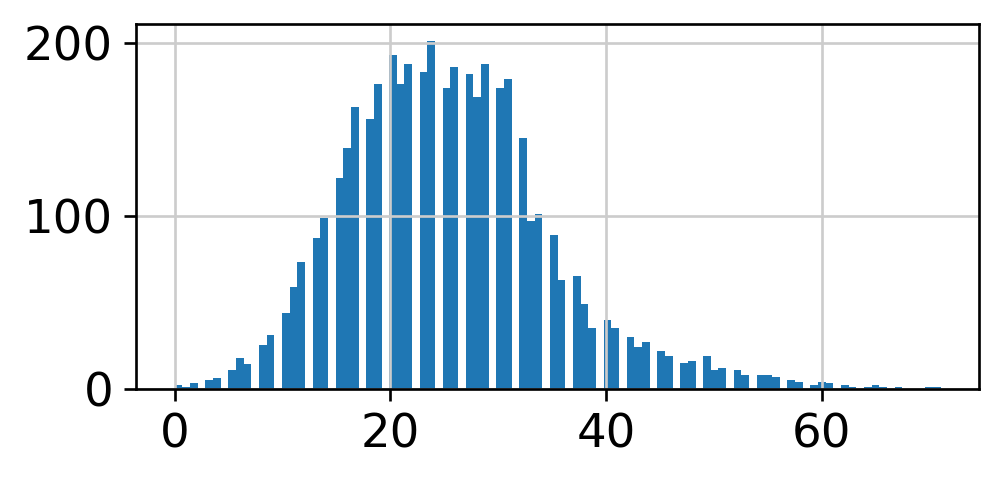

In [31]:
plt.rcParams['figure.figsize'] = 4.5,2
adata_oct.obs['segmentation_label'].hist(bins=100)

In [ ]:
## remove most outer and inner bins, since those are not myocardium
# ad = ad[ad.obs["transmural_axis_bin"]!=ad.obs['transmural_axis_bin'].max()]
# ad = ad[ad.obs["transmural_axis_bin"]!=ad.obs['transmural_axis_bin'].min()]

# multiple by two for the FFPE samples since the thickness is 10um whereas OCT samples are 5um
# cell_id = ad.obs_names[ad.obs['cell2loc-map_group']=='16PCW_FFPE']
# ad.obs.loc[cell_id,'segmentation_label'] = ad.obs.loc[cell_id,'segmentation_label']*2

# Plot

In [39]:
adata_all.obs['cell2loc-map_group'].value_counts()

cell2loc-map_group
16PCW_FFPE    4605
T21_13PCW     1940
13PCW         1837
7PCW           341
5PCW           293
Name: count, dtype: int64

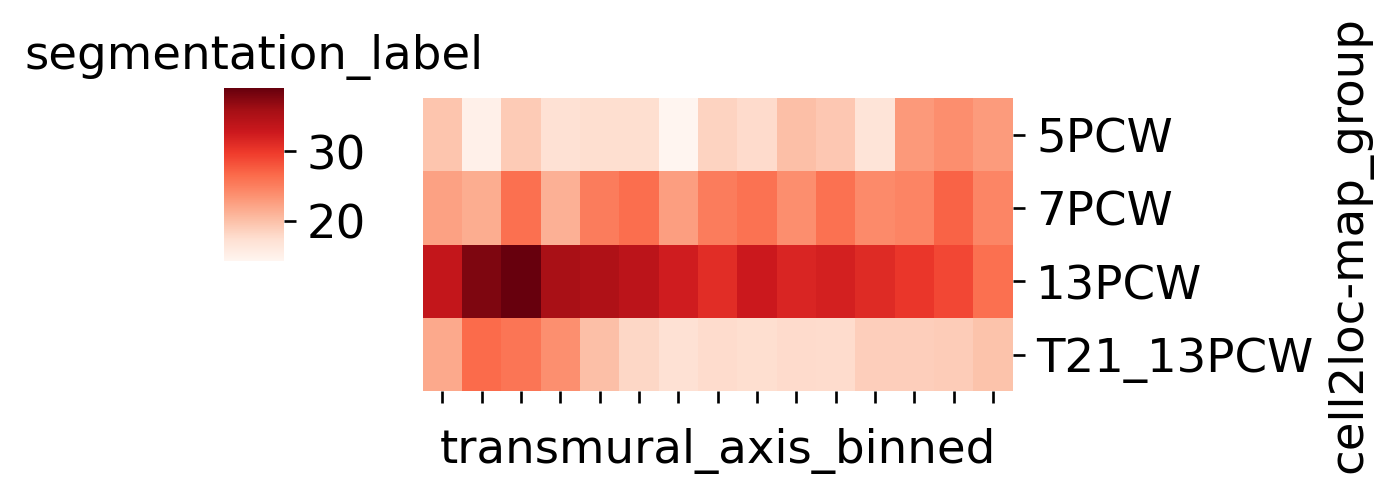

In [42]:
tissueaxis.plot_axis_split(adata_all,
                           feature_to_plot='segmentation_label',
                           feature_type='obs',
                           min_max_scale=False,
                           splitby='cell2loc-map_group',
                           groups_order=[ '5PCW', '7PCW','13PCW','T21_13PCW'],
                           figsize=(5, 4),
                           cbar_pos=(0, 0.7, 0.05, 0.18),
                           cmap='Reds',
                           # save=f'{figdir}/tm-axis_{features_to_plot}_per-week.pdf'
                          )

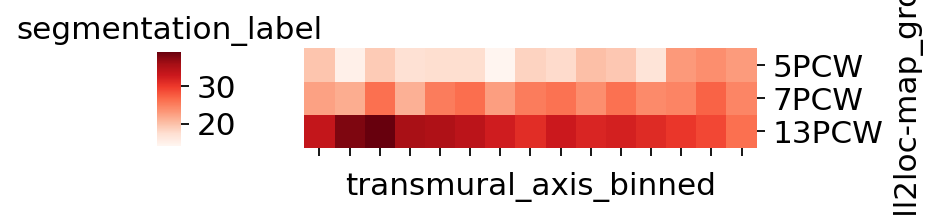

In [56]:
tissueaxis.plot_axis_split(adata_all,
                           feature_to_plot='segmentation_label',
                           feature_type='obs',
                           min_max_scale=False,
                           splitby='cell2loc-map_group',
                           groups_order=[ '5PCW', '7PCW','13PCW'],
                           figsize=(5, 3.25),
                           cbar_pos=(0, 0.7, 0.03, 0.18),
                           cmap='Reds',
                           save=f'{figdir}/tm-axis_nuclei-segmentation_per-week.pdf'
                          )